<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Rui_LightGBM_tuning_ESR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap


#import deepchem as dc
import sklearn as sk


from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer 

#Normalizing
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler


#For data split
from sklearn.model_selection import train_test_split 


#importing Random Forest packages
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import model_selection

# different model
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBRegressor
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
import lightgbm as lgb


In [0]:
esr = pd.read_csv('/content/drive/My Drive/hack7/ESR_features_selection_final.csv')
esr.drop('Unnamed: 0', axis=1, inplace=True)
esr['pIC50'] = np.log(esr['IC50'])

In [0]:
s1 = (((esr['activity_qualifier'] == '>').copy())*1)
s2 = (((esr['activity_qualifier'] == '<').copy())*1)
s0 = s1+s2
# CUTOFFS: > greater
rcutoff = s1 * esr['pIC50'].copy().astype('float64')
#rcutoff = rcutoff.to_numpy()

# CUTOFFS: < lower
lcutoff = s2 * esr['pIC50'].copy().astype('float64')
#lcutoff = lcutoff.to_numpy()

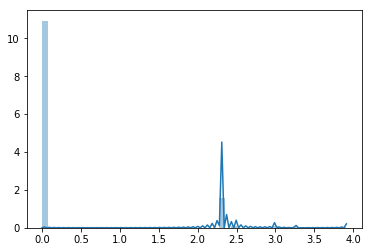

In [8]:
import seaborn as sns
sns.distplot(rcutoff)

In [0]:
y = esr['pIC50']
X = esr.drop(['activity_qualifier', 'IC50', 'smiles', 'Ipc'],axis=1)
X = pd.concat([X, rcutoff, lcutoff, s1, s2, s0], axis=1)

#data split based on sythesis date into train test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
cv_split = model_selection.ShuffleSplit(n_splits=5, test_size=.3, train_size=.6, random_state=0) #  ,return_train_score=True

X_train1, X_test1, y_train1, y_test1 = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

x_train = X_train1.iloc[:,:-6]
x_test  = X_test1.iloc[:,:-6]

s0_train = X_train1.iloc[:,-1].to_numpy()
s2_train = X_train1.iloc[:,-2].to_numpy()
s1_train = X_train1.iloc[:,-3].to_numpy()
lcutoff_train = X_train1.iloc[:,-4].to_numpy()
rcutoff_train = X_train1.iloc[:,-5].to_numpy()


In [79]:
y_train1.loc[s1_train==1].value_counts()

2.302585    612
2.484907     37
2.995732     35
3.258097     21
3.912023     15
Name: pIC50, dtype: int64

In [0]:
def model_tuning(model, dataset, target, cv, score, param_grid, exhausted=False, max_iter=200, score_cutoff=0, scaler=None):
    model = model
    print('Information about model: ')
    print(model)
    print('-'*40)
    if scaler is not None:
        trans = scaler.fit(dataset)
        dataset = trans.transform(dataset)

    best_eval_score = score_cutoff
    for i in range(max_iter):  # Hundred runs
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        print(params)
        train, test, std = evaluate_model(model=model, dataset=dataset, target=np.ravel(target), cv=cv, params=params, score=score)
        print("Run " + str(i) + " train score: " + str(train))
        print("Run " + str(i) + " train score: " + str(test))
        print("Run " + str(i) + " test 3*std: " + str(std))
        if test < best_eval_score or best_eval_score == 0:
            best_eval_score = test
            best_params = params
            print("Best evaluation params", params)

    return best_params

def evaluate_model(model, dataset, target, params, cv, score):
    model = model.set_params(**params)
    score = model_selection.cross_validate(model, dataset, np.ravel(target), cv=cv, return_train_score=True, scoring=score)
    return np.sqrt(score['train_score']*-1).mean(), np.sqrt(score['test_score']*-1).mean(), np.sqrt(score['test_score'] * -1).std()*3


In [0]:
# def custom_asymmetric_train(y, pred):
#     a = 0
    
#     y, pred = np.array(y), np.array(pred)
#     #LS_idx = np.where(y<-4.6)
#     #nor_idx = np.where(y>=-4.6)
#     LS_idx = (y<-4.6) & (y>-4.63)
#     nor_idx = (y>=-4.6) | (y<-4.63)
    
#     y_LS = y[LS_idx]   ###-4.6 is the cutoff
#     ypred_LS = pred[LS_idx]
#     #LS_diff = (y_LS-ypred_LS).astype('float')
#     LS_diff = (ypred_LS-y_LS).astype('float')
#     grad_LS = np.where(LS_diff<0, 2*(-1+a)**2*LS_diff, 2*(1+a)**2*LS_diff)
#     hess_LS = np.where(LS_diff<0, 2*(-1+a)**2, 2*(1+a)**2)
    
#     # normal data
#     y_nor = y[nor_idx] 
#     ypred_nor = pred[nor_idx]
#     nor_diff = (y_nor-ypred_nor).astype('float')
#     grad_nor = -2*nor_diff
#     hess_nor = np.array([2 for x in range(len(y_nor))])
    
#     grad_total = np.zeros(len(y))
#     grad_total[LS_idx] = grad_LS
#     grad_total[nor_idx] = grad_nor
    
#     hess_total = np.zeros(len(y))
#     hess_total[LS_idx] = hess_LS
#     hess_total[nor_idx] = hess_nor
    
#     return grad_total, hess_total



In [0]:
def custom_asymmetric_train(y, pred):
    a = 0
    
    diff = np.array(pred) - np.array(y)
    nor_grad = [-2*diff[i] for i in range(diff.shape[0])]
    ls_grad = [2*(np.sign(x)+a)**2*x for x in diff]
    rs_grad = [2*(np.sign(x)-a)**2*x for x in diff]
    
    nor_hess = [2 for i in range(diff.shape[0])]
    ls_hess = [2*(np.sign(x)+a)**2 for x in diff]
    rs_hess = [2*(np.sign(x)-a)**2 for x in diff]
    
    grad = np.multiply((1-s0_train),nor_grad) + np.multiply(s1_train,rs_grad) + np.multiply(s2_train,ls_grad)
    hess = np.multiply((1-s0_train),nor_hess) + np.multiply(s1_train,rs_hess) + np.multiply(s2_train,ls_hess)
    
    return grad, hess


In [0]:
tmp_y = np.array([0]*len(y_train1))
tmp_test = np.array([1]*len(y_train1))

a=0.3
#custom_asymmetric_train(tmp_y, tmp_test)
diff = tmp_y - tmp_test
nor_grad = [-2*diff[i] for i in range(diff.shape[0])]
ls_grad = [2*(np.sign(x)+a)**2*x for x in diff]
rs_grad = [2*(np.sign(x)-a)**2*x for x in diff]

nor_hess = [2 for i in range(diff.shape[0])]
ls_hess = [2*(np.sign(x)+a)**2 for x in diff]
rs_hess = [2*(np.sign(x)-a)**2 for x in diff]

grad = np.multiply((1-s0_train),nor_grad) + np.multiply(s1_train,rs_grad) + np.multiply(s2_train,ls_grad)
hess = np.multiply((1-s0_train),nor_hess) + np.multiply(s1_train,rs_hess) + np.multiply(s2_train,ls_hess)



In [0]:
Param_list = {
    'Lasso':{'alpha':[5e-05, 0.0002, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20],
             'max_iter':[1500, 3000, 5000, 7000]},
    'Ridge':{'alpha':[0.5, 1.0, 2.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20, 25, 30,40, 50, 70, 90]},
    'LGBMRegressor': {'n_estimators':[100, 300, 500],
            'num_leaves': [10, 20, 40, 60],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [3,6,10,-1],
            'subsample': [0.7, 0.6, 0.8],
            'min_child_samples': [10, 20, 40, 60],
            'colsample_bytree': [1.0, 0.8, 0.6],
            'reg_lambda': [0.1, 0.5, 1, 3, 5],
            'objective': [custom_asymmetric_train]
            }
}

MLA = [
    #linear_model.Ridge(),
    #linear_model.Lasso(),
    #linear_model.ElasticNet(),

    #ensemble.AdaBoostRegressor(),
    #ensemble.GradientBoostingRegressor(),
    #ensemble.RandomForestRegressor(),
    #XGBRegressor(),
    lgb.LGBMRegressor(),
    #svm.SVR()
]

from sklearn.preprocessing import RobustScaler, StandardScaler
ss = StandardScaler()

In [14]:
BestParam_list = {}
for alg in MLA:
    name = alg.__class__.__name__
    param = Param_list[name]

    print(name)
    if name in ['LGBMRegressor', 'GradientBoostingRegressor', 'XGBRegressor']:
        exhausted = False
    else:
        exhausted = True
    best_params = model_tuning(alg, dataset=X_train1, target=y_train1, cv=cv_split,
                                score='neg_mean_squared_error', param_grid=param, exhausted=exhausted, max_iter=100,
                                score_cutoff=50, scaler=None)
    BestParam_list[alg.__class__.__name__] = best_params

LGBMRegressor
Information about model: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
----------------------------------------
{'n_estimators': 100, 'num_leaves': 40, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7, 'min_child_samples': 10, 'colsample_bytree': 0.8, 'reg_lambda': 3.0, 'objective': <function custom_asymmetric_train at 0x7f5dd8f76c80>}
Run 0 train score: 1.8488083154059693
Run 0 train score: 2.1021229844371363
Run 0 test 3*std: 0.14224277096784121
Best evaluation params {'n_estimators': 100, 'num_leaves': 40, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7, '

In [15]:
BestParam_list

{'LGBMRegressor': {'colsample_bytree': 0.8,
  'learning_rate': 0.05,
  'max_depth': -1,
  'min_child_samples': 10,
  'n_estimators': 500,
  'num_leaves': 20,
  'objective': <function __main__.custom_asymmetric_train>,
  'reg_lambda': 3.0,
  'subsample': 0.6}}

In [29]:
lgb_esr = lgb.LGBMRegressor(**BestParam_list['LGBMRegressor'])

#lgb_esr = lgb.LGBMRegressor()
#par = {'n_estimators': 300, 'num_leaves': 40, 'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.8, 'min_child_samples': 60, 'colsample_bytree': 0.8, 'reg_lambda': 1.0,  
#                             'objective': custom_asymmetric_train}

#lgb_esr.set_params(**par)

kf = KFold(n_splits=5, shuffle=True)
cv_all = []
for train_index, test_index in kf.split(X_train1):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #print(len(test_index))
    #print(y_train.shape)
    #print(type(train_index))
    X_cvt, X_valid = X_train1.loc[train_index,:], X_train1.loc[test_index,:]
    y_cvt, y_valid = y_train1.loc[train_index], y_train1.loc[test_index]
    
    #print(X_cvt.shape)
    #print(y_cvt.shape)
    lgb_esr.fit(
    X_cvt,
    y_cvt,
    verbose=False)
    
    cv_pred = lgb_esr.predict(X_valid)
    r2 = r2_score(y_valid, cv_pred)
    print('r2 is {}'.format(r2))
    cv_all.append(r2)

print('average r2 is {}'.format(np.mean(cv_all)))

r2 is 0.7616893455228767
r2 is 0.7710416352642016
r2 is 0.8254853826392163
r2 is 0.7924316135885925
r2 is 0.7623348719952616
average r2 is 0.7825965698020297


## Tune alpha in cost function

In [0]:
# def custom_asymmetric_train(y, pred):
#     a = 0
    
#     diff = np.array(pred) - np.array(y)
#     nor_grad = [-2*diff[i] for i in range(diff.shape[0])]
#     ls_grad = [2*(np.sign(x)+a)**2*x for x in diff]
#     rs_grad = [2*(np.sign(x)-a)**2*x for x in diff]
    
#     nor_hess = [2 for i in range(diff.shape[0])]
#     ls_hess = [2*(np.sign(x)+a)**2 for x in diff]
#     rs_hess = [2*(np.sign(x)-a)**2 for x in diff]
    
#     grad = np.multiply((1-s0_train),nor_grad) + np.multiply(s1_train,rs_grad) + np.multiply(s2_train,ls_grad)
#     hess = np.multiply((1-s0_train),nor_hess) + np.multiply(s1_train,rs_hess) + np.multiply(s2_train,ls_hess)
    
#     return grad, hess


In [0]:
def custom_asymmetric_train(y, pred):
    a = -0.7
    
    y, pred = np.array(y), np.array(pred)
    
    LS_idx = ((y>2.302) & (y<2.303)) |  ((y>2.484) & (y<2.485)) | ((y>2.995) & (y<2.996)) | ((y>3.258) & (y<3.259)) | ((y>3.912) & (y<3.913)) 
    nor_idx = ~LS_idx
    
    y_LS = y[LS_idx]   ###-4.6 is the cutoff
    ypred_LS = pred[LS_idx]
    #LS_diff = (y_LS-ypred_LS).astype('float')
    LS_diff = (ypred_LS-y_LS).astype('float')
    grad_LS = np.where(LS_diff<0, 2*(-1+a)**2*LS_diff, 2*(1+a)**2*LS_diff)
    hess_LS = np.where(LS_diff<0, 2*(-1+a)**2, 2*(1+a)**2)
    
    # normal data
    y_nor = y[nor_idx] 
    ypred_nor = pred[nor_idx]
    nor_diff = (y_nor-ypred_nor).astype('float')
    grad_nor = -2*nor_diff
    hess_nor = np.array([2 for x in range(len(y_nor))])
    
    grad_total = np.zeros(len(y))
    grad_total[LS_idx] = grad_LS
    grad_total[nor_idx] = grad_nor
    
    hess_total = np.zeros(len(y))
    hess_total[LS_idx] = hess_LS
    hess_total[nor_idx] = hess_nor
    
    return grad_total, hess_total



In [120]:
y_train1.loc[s1_train==1].value_counts()

2.302585    612
2.484907     37
2.995732     35
3.258097     21
3.912023     15
Name: pIC50, dtype: int64

In [131]:
par = {'n_estimators': 500, 'num_leaves': 40, 'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.8, 'min_child_samples': 10, 'colsample_bytree': 0.6, 'reg_lambda': 0.1,
      'objective': custom_asymmetric_train}
#lgb_esr = lgb.LGBMRegressor(**BestParam_list['LGBMRegressor'])
lgb_esr = lgb.LGBMRegressor()
lgb_esr.set_params(**par)

# kf = KFold(n_splits=5, shuffle=True)
# cv_all = []
# for train_index, test_index in kf.split(X_train1):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     #print(len(test_index))
#     #print(y_train.shape)
#     #print(type(train_index))
#     X_cvt, X_valid = X_train1.loc[train_index,:], X_train1.loc[test_index,:]
#     y_cvt, y_valid = y_train1.loc[train_index], y_train1.loc[test_index]
    
#     #print(X_cvt.shape)
#     #print(y_cvt.shape)
#     lgb_esr.fit(
#     X_cvt,
#     y_cvt,
#     verbose=False)
    
#     cv_pred = lgb_esr.predict(X_valid)
#     r2 = r2_score(y_valid, cv_pred)
#     print('r2 is {}'.format(r2))
#     cv_all.append(r2)

lgb_esr.fit(
    x_train,
    y_train1,
    verbose=False)

test_pred = lgb_esr.predict(x_test)  #y_test1   test_pred
r2 = r2_score(y_test1, test_pred)
print('R2 is {}'.format(r2))
#print('average r2 is {}'.format(np.mean(cv_all)))

R2 is 0.7869514154415438


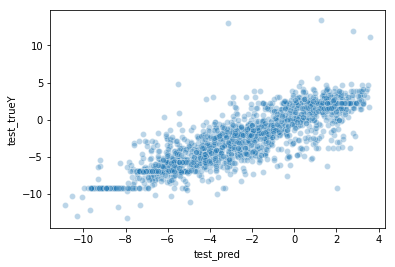

In [124]:
import seaborn as sns


# ax = sns.scatterplot(x=train_pred, y=y_train1)
# ax.set(xlabel='train_pred', ylabel='train_trueY')

#test_pred = XGB_NR.predict(X_test1)

plt.figure()
ax = sns.scatterplot(x=test_pred, y=y_test1, alpha=0.3)
ax.set(xlabel='test_pred', ylabel='test_trueY')
plt.show()